# Preprocess CRC data

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import InSituData, InSituExperiment, CACHE
import scanpy as sc
from tqdm import tqdm
import anndata
import pandas as pd

## Reload after proseg addition

In [3]:
#adata_path = Path("D:/ColorectalCancer/analysis/adata_export/")
adata_path = Path("/dss/dssfs02/lwp-dss-0001/pn57fo/pn57fo-dss-0000/projects/2301-CRC/adata_export_proseg")
adata_files = adata_path.glob("*.h5ad")

adatas = {}
for f in adata_files:
    adatas[f.stem] = sc.read(f)

In [4]:
adata = anndata.concat(adatas, label="uid")

In [5]:
adata

AnnData object with n_obs × n_vars = 673379 × 280
    obs: 'original_cell_id', 'centroid_x', 'centroid_y', 'centroid_z', 'fov', 'cluster', 'volume', 'scale', 'population', 'n_genes_by_counts', 'total_counts', 'n_counts', 'n_genes', 'uid'
    obsm: 'spatial'
    layers: 'counts', 'counts_rounded', 'log1p', 'norm_counts', 'scaled_log1p'

### Add ensembl IDs

In [6]:
df = pd.read_csv("/dss/dssfs02/lwp-dss-0001/pn57fo/pn57fo-dss-0000/projects/2301-CRC/gene_to_ensemblid.csv", index_col=0)

gene_to_ensembl_dict = df.to_dict()["gene_ids"]

In [7]:
adata.var["ensembl_ids"] = [gene_to_ensembl_dict[elem] for elem in adata.var_names]

In [8]:
adata.var = adata.var.reset_index(names="gene_names").set_index("ensembl_ids")

In [9]:
adata

AnnData object with n_obs × n_vars = 673379 × 280
    obs: 'original_cell_id', 'centroid_x', 'centroid_y', 'centroid_z', 'fov', 'cluster', 'volume', 'scale', 'population', 'n_genes_by_counts', 'total_counts', 'n_counts', 'n_genes', 'uid'
    var: 'gene_names'
    obsm: 'spatial'
    layers: 'counts', 'counts_rounded', 'log1p', 'norm_counts', 'scaled_log1p'

### Check proseg decimals

In [10]:
ar = adata.layers['counts'].toarray().flatten()

In [11]:
ar

array([1.3700538, 0.3500035, 0.1400114, ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [15]:
decimal = np.modf(ar)[0]

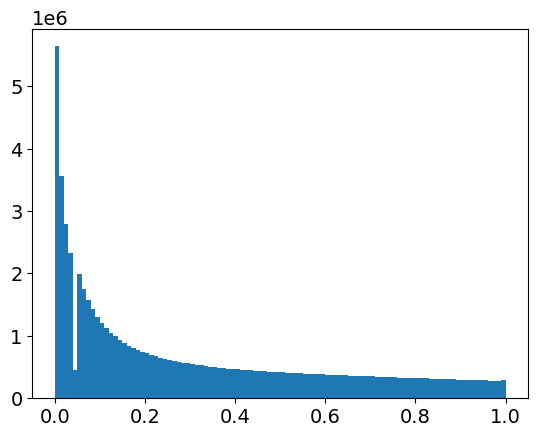

In [16]:
plt.hist(decimal[decimal > 0], bins=100)
plt.show()

## Load sampled reference

In [17]:
n_cells = 5000
ref_path = Path(f"/dss/dssfs02/lwp-dss-0001/pn57fo/pn57fo-dss-0000/datasets/scRNAseq_CRC_atlas/crc_atlas_sampled_max{n_cells}.h5ad")

In [18]:
reference = sc.read(ref_path)

In [19]:
reference

AnnData object with n_obs × n_vars = 125438 × 28476
    obs: 'dataset', 'medical_condition', 'cancer_type', 'sample_id', 'sample_type', 'tumor_source', 'replicate', 'sample_tissue', 'anatomic_region', 'anatomic_location', 'tumor_stage', 'tumor_stage_TNM', 'tumor_stage_TNM_T', 'tumor_stage_TNM_N', 'tumor_stage_TNM_M', 'tumor_size', 'tumor_dimensions', 'tumor_grade', 'histological_type', 'microsatellite_status', 'mismatch_repair_deficiency_status', 'MLH1_promoter_methylation_status', 'MLH1_status', 'KRAS_status', 'BRAF_status', 'APC_status', 'TP53_status', 'PIK3CA_status', 'SMAD4_status', 'NRAS_status', 'MSH6_status', 'FBXW7_status', 'NOTCH1_status', 'MSH2_status', 'PMS2_status', 'POLE_status', 'ERBB2_status', 'STK11_status', 'HER2_status', 'CTNNB1_status', 'BRAS_status', 'patient_id', 'sex', 'age', 'treatment_status_before_resection', 'treatment_drug', 'treatment_response', 'RECIST', 'platform', 'platform_fine', 'cellranger_version', 'reference_genome', 'matrix_type', 'enrichment_cell_t

In [20]:
len(set(adata.var_names) & set(reference.var_names))

280

## Filter genes in reference

In [21]:
reference = reference[:, adata.var_names].copy()

In [22]:
reference

AnnData object with n_obs × n_vars = 125438 × 280
    obs: 'dataset', 'medical_condition', 'cancer_type', 'sample_id', 'sample_type', 'tumor_source', 'replicate', 'sample_tissue', 'anatomic_region', 'anatomic_location', 'tumor_stage', 'tumor_stage_TNM', 'tumor_stage_TNM_T', 'tumor_stage_TNM_N', 'tumor_stage_TNM_M', 'tumor_size', 'tumor_dimensions', 'tumor_grade', 'histological_type', 'microsatellite_status', 'mismatch_repair_deficiency_status', 'MLH1_promoter_methylation_status', 'MLH1_status', 'KRAS_status', 'BRAF_status', 'APC_status', 'TP53_status', 'PIK3CA_status', 'SMAD4_status', 'NRAS_status', 'MSH6_status', 'FBXW7_status', 'NOTCH1_status', 'MSH2_status', 'PMS2_status', 'POLE_status', 'ERBB2_status', 'STK11_status', 'HER2_status', 'CTNNB1_status', 'BRAS_status', 'patient_id', 'sex', 'age', 'treatment_status_before_resection', 'treatment_drug', 'treatment_response', 'RECIST', 'platform', 'platform_fine', 'cellranger_version', 'reference_genome', 'matrix_type', 'enrichment_cell_typ

### Remove cells with zero counts

In [23]:
reference = reference[reference.layers["counts"].toarray().sum(axis=1) > 0].copy()

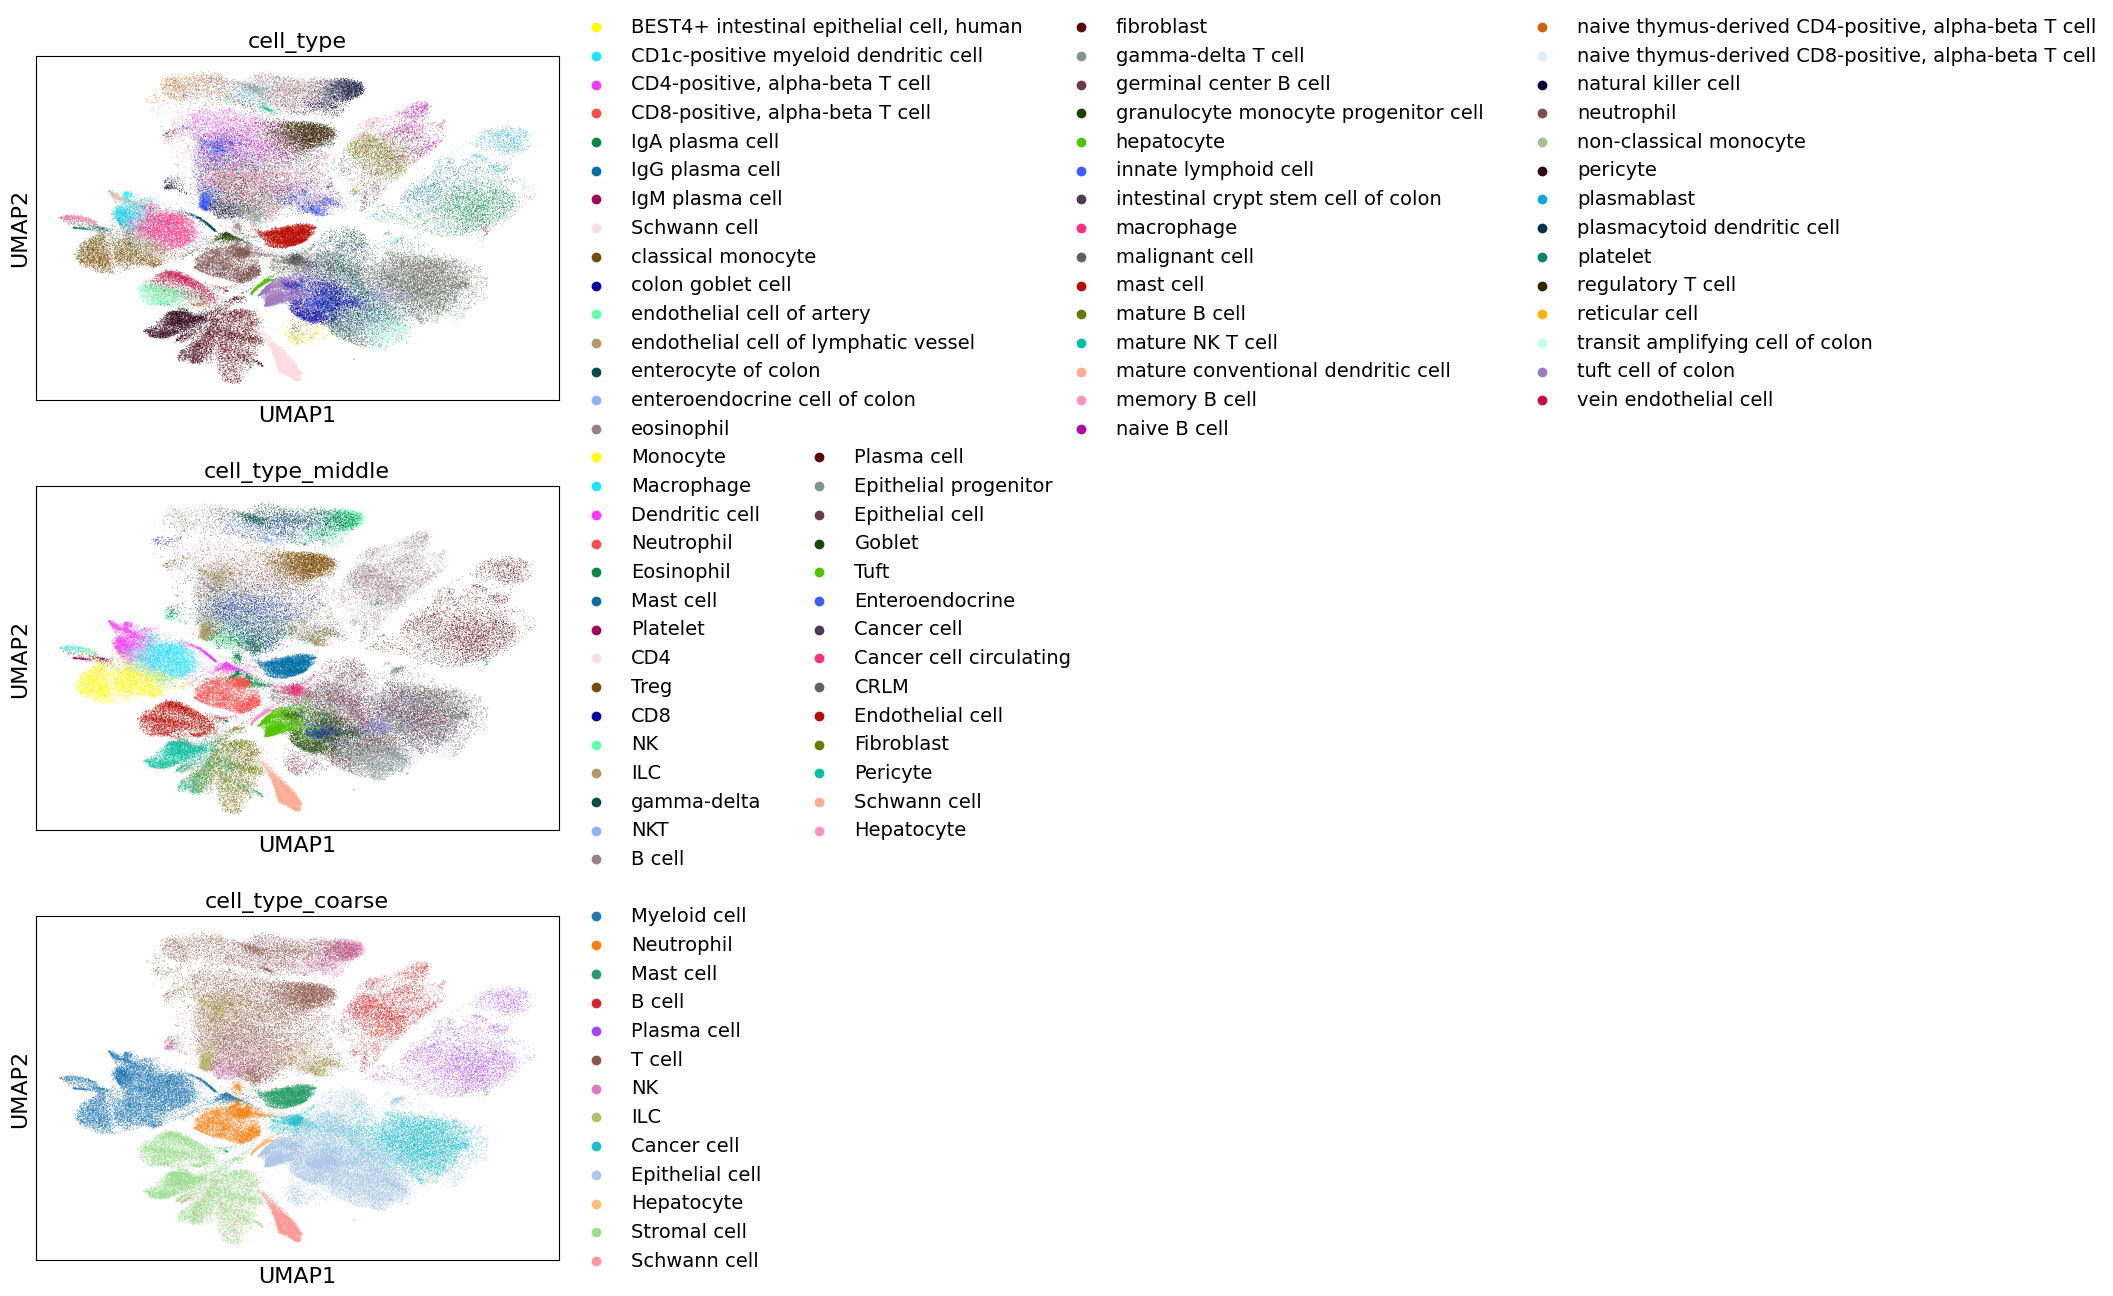

In [24]:
sc.pl.umap(reference, color=["cell_type", "cell_type_middle", "cell_type_coarse"], ncols=1)

## Round the proseg counts and put them into `adata.X`

In [25]:
from scipy.sparse import csr_matrix
from insitupy.plotting import plot_qc_metrics

In [26]:
adata

AnnData object with n_obs × n_vars = 673379 × 280
    obs: 'original_cell_id', 'centroid_x', 'centroid_y', 'centroid_z', 'fov', 'cluster', 'volume', 'scale', 'population', 'n_genes_by_counts', 'total_counts', 'n_counts', 'n_genes', 'uid'
    var: 'gene_names'
    obsm: 'spatial'
    layers: 'counts', 'counts_rounded', 'log1p', 'norm_counts', 'scaled_log1p'

In [19]:
#adata.layers["counts"] = csr_matrix(adata.layers["counts"].toarray().round())

In [27]:
for l in list(adata.layers.keys()):
    if l != "counts":
        del adata.layers[l]

adata.X = adata.layers["counts"]

In [28]:
sc.pp.calculate_qc_metrics(
    adata, percent_top=None, log1p=False, inplace=True
    )

/dss/dsshome1/0C/ge37voy2/github/InSituPy/insitupy/plotting/qc.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


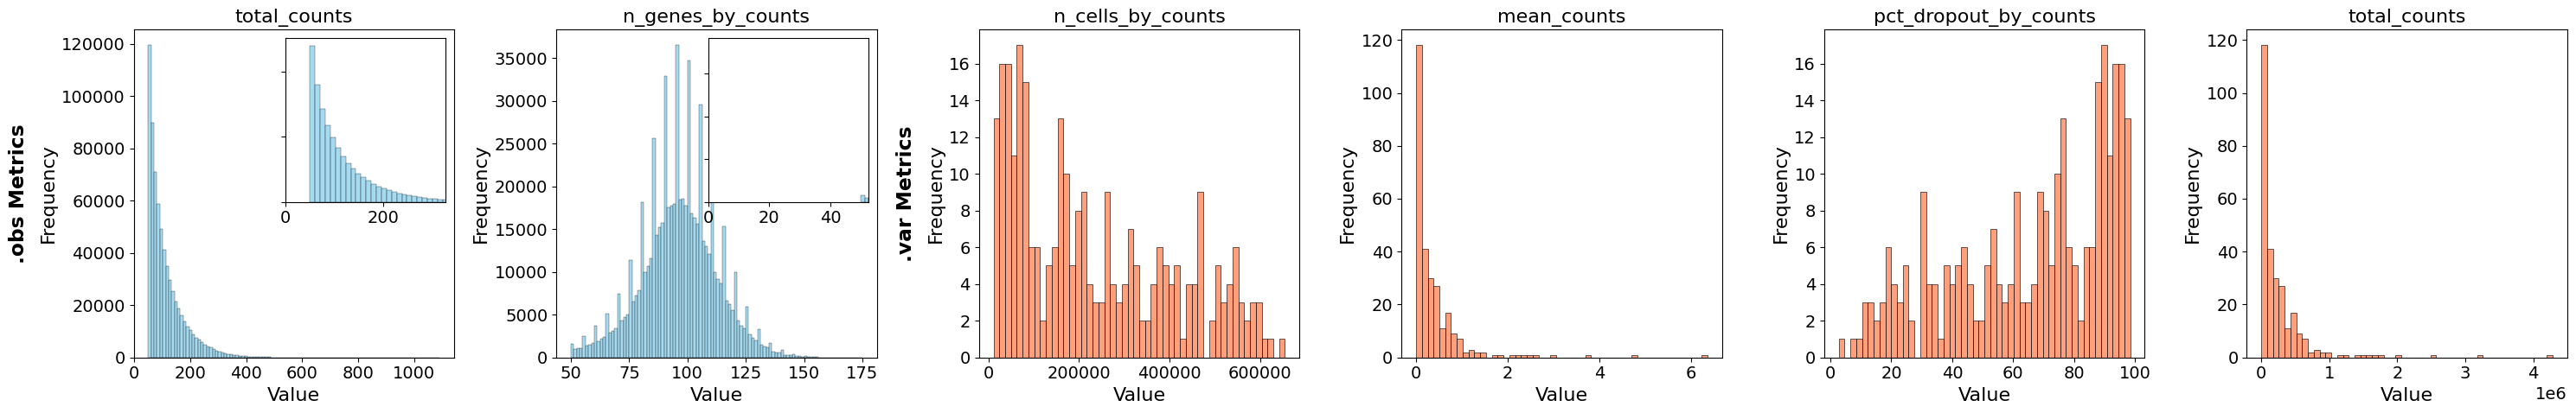

In [31]:
plot_qc_metrics(adata, 0.3)

## Normalize and transform data and reference

In [32]:
from insitupy.preprocessing.anndata import normalize_and_transform_anndata

In [35]:
adata1e2 = adata.copy()
adata1e4 = adata.copy()

reference1e2 = reference.copy()
reference1e4 = reference.copy()

In [36]:
normalize_and_transform_anndata(
    adata=adata1e2, #layer='counts', 
    transformation_method='log1p', target_sum=100, scale=False, assert_integer_counts=False
)

Store raw counts in .layers['counts'].
Normalization with target sum 100.
Perform log1p-transformation.


In [37]:
normalize_and_transform_anndata(
    adata=adata1e4, #layer='counts', 
    transformation_method='log1p', target_sum=10000, scale=False, assert_integer_counts=False
)

Store raw counts in .layers['counts'].
Normalization with target sum 10000.
Perform log1p-transformation.


In [38]:
normalize_and_transform_anndata(
    adata=reference1e2, layer='counts', transformation_method='log1p', target_sum=100, scale=False
)

Retrieve raw counts from .layers['counts'].
Normalization with target sum 100.
Perform log1p-transformation.


In [39]:
normalize_and_transform_anndata(
    adata=reference1e4, layer='counts', transformation_method='log1p', target_sum=10000, scale=False
)

Retrieve raw counts from .layers['counts'].
Normalization with target sum 10000.
Perform log1p-transformation.


In [40]:
adata1e2.write(adata_path.parent / "celltypist/adata_pp1e2.h5ad")
adata1e4.write(adata_path.parent / "celltypist/adata_pp1e4.h5ad")

In [41]:
reference1e2.write(adata_path.parent / f"celltypist/reference_{n_cells}_pp1e2.h5ad")
reference1e4.write(adata_path.parent / f"celltypist/reference_{n_cells}_pp1e4.h5ad")

In [49]:
reference1e2

AnnData object with n_obs × n_vars = 125414 × 280
    obs: 'dataset', 'medical_condition', 'cancer_type', 'sample_id', 'sample_type', 'tumor_source', 'replicate', 'sample_tissue', 'anatomic_region', 'anatomic_location', 'tumor_stage', 'tumor_stage_TNM', 'tumor_stage_TNM_T', 'tumor_stage_TNM_N', 'tumor_stage_TNM_M', 'tumor_size', 'tumor_dimensions', 'tumor_grade', 'histological_type', 'microsatellite_status', 'mismatch_repair_deficiency_status', 'MLH1_promoter_methylation_status', 'MLH1_status', 'KRAS_status', 'BRAF_status', 'APC_status', 'TP53_status', 'PIK3CA_status', 'SMAD4_status', 'NRAS_status', 'MSH6_status', 'FBXW7_status', 'NOTCH1_status', 'MSH2_status', 'PMS2_status', 'POLE_status', 'ERBB2_status', 'STK11_status', 'HER2_status', 'CTNNB1_status', 'BRAS_status', 'patient_id', 'sex', 'age', 'treatment_status_before_resection', 'treatment_drug', 'treatment_response', 'RECIST', 'platform', 'platform_fine', 'cellranger_version', 'reference_genome', 'matrix_type', 'enrichment_cell_typ

# Test celltypist

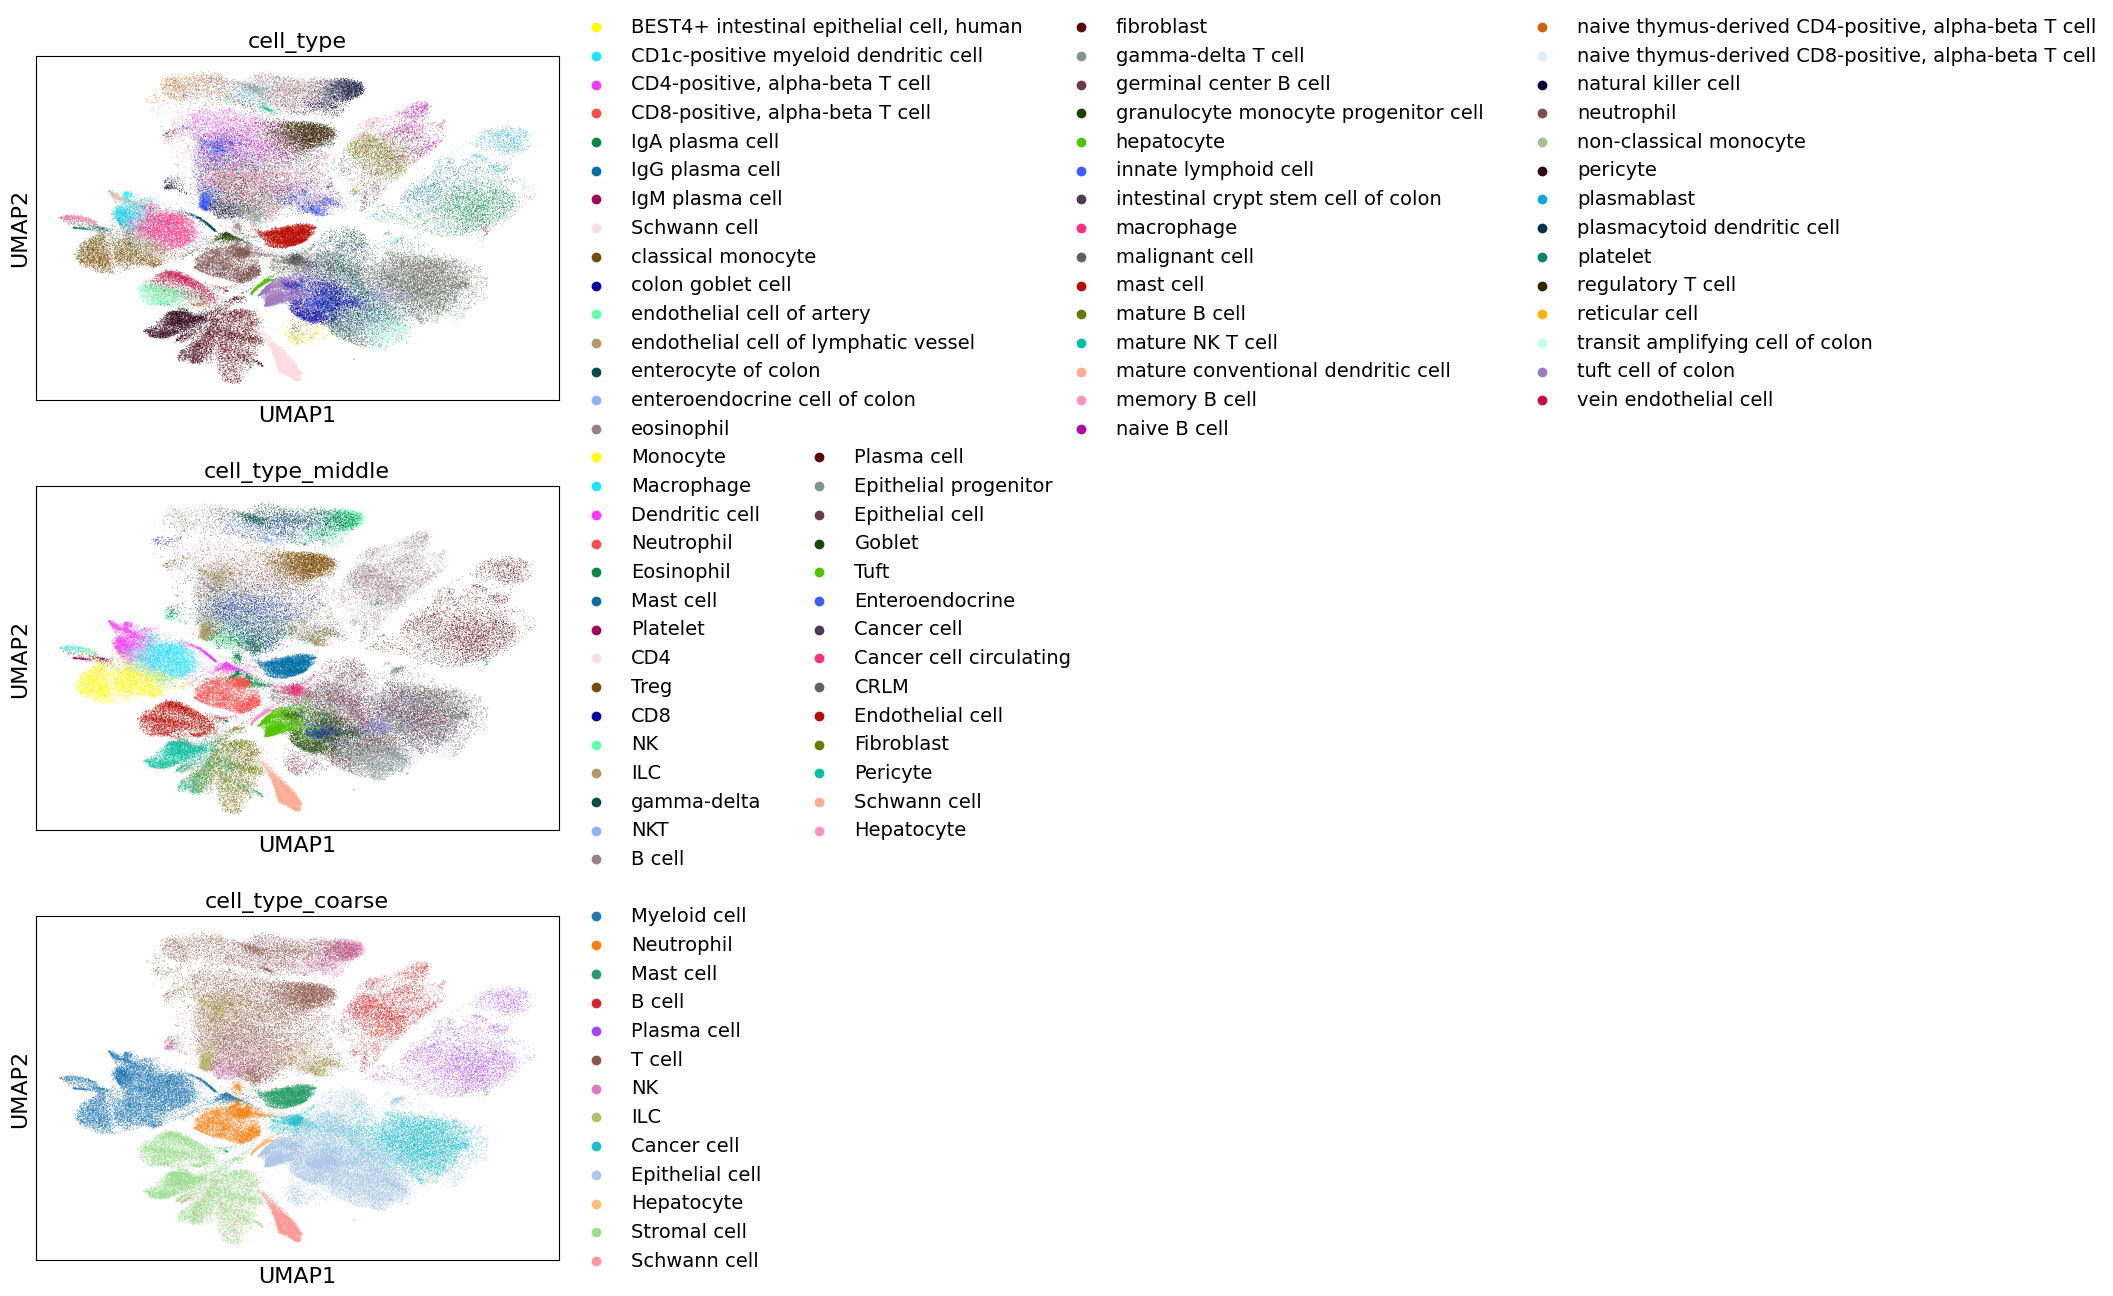

In [46]:
sc.pl.umap(reference1e2, color=["cell_type", "cell_type_middle", "cell_type_coarse"], ncols=1)

In [47]:
import celltypist

## Mistake in preprocessing pipeline - need to normalize again

In [48]:
from insitupy.preprocessing.anndata import normalize_and_transform_anndata
import numpy as np
import time

In [23]:
normalize_and_transform_anndata(
    adata=reference, layer='counts', transformation_method='log1p', target_sum=100, scale=False
)

Retrieve raw counts from .layers['counts'].
Normalization with target sum 100.
Perform log1p-transformation.


In [26]:
reference.layers['counts'][:10, :10].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [27]:
reference.X[:10, :10].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.6256326 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.90445627, 0.        , 0.        ],
       [0.98082925, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [25]:
# Add `check_expression = False` to bypass expression check with only a subset of genes.
t_start = time.time()
model = celltypist.train(reference, 'cell_type_middle', check_expression = False, n_jobs = 10, max_iter = 100)
t_end = time.time()
print(f"Time elapsed: {(t_end - t_start)/60} minutes")

🍳 Preparing data before training
✂️ 1 non-expressed genes are filtered out
🔬 Input data has 5800 cells and 279 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!


Time elapsed: 0.06737529039382935 minutes


In [26]:
# Save the model.
model_path = adata_path.parent / f'crc_atlas_model_max{n_cells}.pkl'
model.write(model_path)

In [27]:
# CellTypist prediction without over-clustering and majority-voting.
t_start = time.time()
predictions = celltypist.annotate(adata[:1000], model = str(model_path), majority_voting = True)
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 1000 cells and 280 genes
🔗 Matching reference genes in the model
🧬 279 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
/dss/dsshome1/0C/ge37voy2/miniconda3/envs/insitupy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


Time elapsed: 9.812845468521118 seconds


In [28]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
13613e64-aaabcimi-1,Endothelial cell,15,CD8
13613e64-aaabffej-1,Pericyte,15,CD8
13613e64-aaacannb-1,Fibroblast,10,Fibroblast
13613e64-aaacjbge-1,CD4,15,CD8
13613e64-aaackdnh-1,Fibroblast,17,Fibroblast
...,...,...,...
13613e64-abjeojdd-1,Goblet,2,Cancer cell
13613e64-abjfanbn-1,Enteroendocrine,2,Cancer cell
13613e64-abjfbffk-1,Epithelial cell,24,CRLM
13613e64-abjffadk-1,CRLM,2,Cancer cell


In [31]:
predictions

CellTypist prediction result for 1000 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 1000 query cells and 29 cell types
    probability_matrix: data frame with 1000 query cells and 29 cell types
    adata: AnnData object referred

In [34]:
predictions.adata

AnnData object with n_obs × n_vars = 1000 × 280
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'n_genes', 'uid'
    var: 'gene_names'
    uns: 'log1p', 'neighbors', 'over_clustering'
    obsm: 'spatial', 'X_pca'
    layers: 'counts', 'norm_counts', 'scaled_log1p'
    obsp: 'connectivities', 'distances'

In [35]:
result = predictions.to_adata()

In [37]:
result.obs["majority_voting"]

13613e64-aaabcimi-1            CD8
13613e64-aaabffej-1            CD8
13613e64-aaacannb-1     Fibroblast
13613e64-aaacjbge-1            CD8
13613e64-aaackdnh-1     Fibroblast
                          ...     
13613e64-abjeojdd-1    Cancer cell
13613e64-abjfanbn-1    Cancer cell
13613e64-abjfbffk-1           CRLM
13613e64-abjffadk-1    Cancer cell
13613e64-abjfnhni-1    Cancer cell
Name: majority_voting, Length: 1000, dtype: category
Categories (10, object): ['CD8', 'CRLM', 'Cancer cell', 'Endothelial cell', ..., 'Mast cell', 'Pericyte', 'Plasma cell', 'Treg']

In [ ]:
1+1